In [68]:
import collections
import itertools
import logging
import os.path
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.preprocessing

from sklearn.metrics import check_scoring, r2_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, check_cv, KFold

from IPython.display import display_html

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(name)s: %(message)s")

import compute

### Prepare data

In [ ]:
fn_study_prepared = "studydata.pickle"
df_study1, df_study2 = compute.load_cached_data(fn_study_prepared)

if False:
    # fill missing columns
    for col in set(df_study2.columns).difference(df_study1.columns):
        df_study1.insert(len(df_study1.columns), col, None)

    # stack together (columns need to be same)
    cols = df_study2.columns.sort_values()
    pd.concat([df_study1[cols], df_study2[cols]], axis=0, ignore_index=True)

In [3]:
# X, y train/test data

# X
df_study1_text = df_study1[[compute.COL_TEXT, compute.COL_TEXT_SPACY, compute.COL_TEXT_SPACY_CLEAN]]
df_study2_text = df_study2[[compute.COL_TEXT, compute.COL_TEXT_SPACY, compute.COL_TEXT_SPACY_CLEAN]]
df_both_text = pd.concat([df_study1_text, df_study2_text], axis=0).reset_index(drop=True)

# y
df_study1_scores = df_study1[compute.COLS_SCORES]
df_study2_scores = df_study2[compute.COLS_SCORES + compute.COLS_SCORES_S2]
df_both_scores = pd.concat([df_study1_scores, df_study2_scores[compute.COLS_SCORES]], axis=0).reset_index(drop=True)

# X
df_study1_liwc = df_study1[compute.COLS_LIWC_REL]
df_study2_liwc = df_study2[compute.COLS_LIWC_REL]
df_both_liwc = pd.concat([df_study1_liwc, df_study2_liwc], axis=0).reset_index(drop=True)

In [4]:
# build standard document-term matrix

def build_dtm_df(df_study, binarize=False):
    df = df_study[compute.COL_TEXT_SPACY_CLEAN]
    doc_term_mat, features = compute.build_feature_matrix(df, norm="l2", use_idf=True)

    # binarize (0/1 instead of floats)
    if binarize:
        doc_term_mat = np.array(np.vectorize(round)(doc_term_mat.todense()))
    else:
        doc_term_mat = doc_term_mat.toarray()

    return pd.DataFrame(doc_term_mat, columns=features)


binarize = False
# X
df_study1_dtm = build_dtm_df(df_study1_text, binarize=binarize)
df_study2_dtm = build_dtm_df(df_study2_text, binarize=binarize)
df_both_dtm = build_dtm_df(df_both_text, binarize=binarize)

In [5]:
# Rescale LIWC values into [0, 1] range, per column

def scale_liwc_df(df_study):
    scaler = StandardScaler()
    #scaler = MinMaxScaler()

    scaler.fit(df_study[compute.COLS_LIWC_REL])
    scaler.feature_names_in_
    #scaler.scale_, scaler.mean_  # StandardScaler

    data = scaler.transform(df_study[compute.COLS_LIWC_REL])
    return pd.DataFrame(data, columns=scaler.feature_names_in_)


# X
df_study1_liwc_scaled = scale_liwc_df(df_study1_liwc)
df_study2_liwc_scaled = scale_liwc_df(df_study2_liwc)
df_both_liwc_scaled = scale_liwc_df(df_both_liwc)

In [6]:
# Collapse variables into three classes (low/mid/high) based on quantiles

def quantize_scores(scores, as_str=False):
    # split by quantiles into 3 parts
    q33 = np.quantile(scores, 1 / 3)
    q66 = np.quantile(scores, 2 / 3)

    idx = np.digitize(scores, [q33, q66], right=True)

    # validate
    # assert all([
    #     v <= q33 if x == 0 else v > q33 and v <= q66 if x == 1 else v > q66
    #     for v, x in [(scores[i], x) for i, x in enumerate(idx)]
    # ])

    if not as_str:
        return idx

    # map to class labels
    return np.vectorize({0: "low", 1: "mid", 2: "high"}.get)(idx)


def quantize_score_df(df_scores, cols, as_str=False):
    all_scores = dict()
    for col in cols:
        all_scores[col] = quantize_scores(df_scores[col], as_str=as_str)
    return pd.DataFrame.from_dict(all_scores)


as_str = False
# y
df_study1_scores_cls = quantize_score_df(df_study1_scores, compute.COLS_SCORES, as_str=as_str)
df_study2_scores_cls = quantize_score_df(df_study2_scores, compute.COLS_SCORES + compute.COLS_SCORES_S2, as_str=as_str)
df_both_scores_cls = quantize_score_df(df_both_scores, compute.COLS_SCORES, as_str=as_str)

### Train Classifiers / Regressions

In [17]:
sels_features = ["DTM", "LIWC", "LIWC_S", "DTM+LIWC", "DTM+LIWC_S"]
sels_study = ["S1", "S2", "S1+S2"]
sels_var = ["power", "dominance", "prestige", "power_f", "dominance_f", "prestige_f"]


def select_data(sel_features, sel_study):
    df_dtm = None
    if sel_features == "DTM":
        if sel_study == "S1":
            df_dtm = df_study1_dtm
        elif sel_study == "S2":
            df_dtm = df_study2_dtm
        elif sel_study == "S1+S2":
            df_dtm = df_both_dtm
    elif sel_features == "LIWC":
        if sel_study == "S1":
            df_dtm = df_study1_liwc
        elif sel_study == "S2":
            df_dtm = df_study2_liwc
        elif sel_study == "S1+S2":
            df_dtm = df_both_liwc
    elif sel_features == "LIWC_S":
        if sel_study == "S1":
            df_dtm = df_study1_liwc_scaled
        elif sel_study == "S2":
            df_dtm = df_study2_liwc_scaled
        elif sel_study == "S1+S2":
            df_dtm = df_both_liwc_scaled
    elif sel_features == "DTM+LIWC":
        if sel_study == "S1":
            df_dtm = pd.concat([df_study1_dtm, df_study1_liwc], axis=1)
        elif sel_study == "S2":
            df_dtm = pd.concat([df_study2_dtm, df_study2_liwc], axis=1)
        elif sel_study == "S1+S2":
            df_dtm = pd.concat([df_both_dtm, df_both_liwc], axis=1)
    elif sel_features == "DTM+LIWC_S":
        if sel_study == "S1":
            df_dtm = pd.concat([df_study1_dtm, df_study1_liwc_scaled], axis=1)
        elif sel_study == "S2":
            df_dtm = pd.concat([df_study2_dtm, df_study2_liwc_scaled], axis=1)
        elif sel_study == "S1+S2":
            df_dtm = pd.concat([df_both_dtm, df_both_liwc_scaled], axis=1)
    assert df_dtm is not None
    return df_dtm


def select_scores(sel_study, sel_var):
    df_scores = None
    if sel_study == "S1":
        df_scores = df_study1_scores
    elif sel_study == "S2":
        df_scores = df_study2_scores
    elif sel_study == "S1+S2":
        df_scores = df_both_scores
    assert df_scores is not None
    col = f"s:{sel_var}"
    assert col in df_scores.columns
    return df_scores[col].to_numpy()

In [8]:
def run_trials(X, y, clf, p_grid, num_trials):
    scores = np.zeros(num_trials)
    params = []

    # Loop for each trial
    for i in range(num_trials):
        # cross-validation techniques for the inner and outer loops
        # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
        inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        # clf_gs = GridSearchCV(estimator=clf, param_grid=p_grid, cv=outer_cv)
        # clf_gs.fit(X, y)
        # clf.cv_results_

        # Nested CV with parameter optimization
        clf_gs = GridSearchCV(estimator=clf, param_grid=p_grid, cv=inner_cv, verbose=0)
        #score = cross_val_score(clf_gs, X=X, y=y, cv=outer_cv)

        scorer = check_scoring(clf_gs, scoring=None)
        cv_results = cross_validate(
            estimator=clf_gs,
            X=X,
            y=y,
            scoring={"score": scorer},
            cv=outer_cv,
            return_estimator=True
        )
        score = cv_results["test_score"]
        best_params = cv_results["estimator"][score.argmax()].best_params_

        scores[i] = score.mean()
        params.append(best_params)

    return scores, params

---

#### Singular tests

In [9]:
sel_study = "S1+S2"         # one of: S1, S2, S1+S2
sel_features = "DTM+LIWC"   # one of: DTM, LIWC, LIWC_S, DTM+LIWC, DTM+LIWC_S
sel_var = "power"           # one of: power, dominance, prestige, power_f, dominance_f, prestige_f

X = select_data(sel_features, sel_study).values
y = select_scores(sel_study, sel_var)

# convert continuous y variable to class variable
#y_cls = y.round()
#y_cls = y.astype(int)
y_cls = np.vectorize(round)(y)
y_lmh = quantize_scores(y)

Classification models

In [10]:
clf = sklearn.svm.SVC(kernel="rbf")
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

scores, params = run_trials(X, y_cls, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame.from_dict(dict(zip(scores, params)))
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'C': 1, 'gamma': 0.01}


,scores,params
0,0.345000,"{'C': 1, 'gamma': 0.01}"
1,0.345000,"{'C': 10, 'gamma': 0.01}"
2,0.327500,"{'C': 1, 'gamma': 0.01}"
3,0.335000,"{'C': 1, 'gamma': 0.01}"
4,0.357500,"{'C': 1, 'gamma': 0.01}"


In [11]:
clf = sklearn.svm.SVC(kernel="rbf")
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

scores, params = run_trials(X, y_lmh, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'C': 1, 'gamma': 0.1}


,scores,params
0,0.382500,"{'C': 1, 'gamma': 0.01}"
1,0.382500,"{'C': 1, 'gamma': 0.01}"
2,0.382500,"{'C': 10, 'gamma': 0.01}"
3,0.327500,"{'C': 1, 'gamma': 0.01}"
4,0.382500,"{'C': 1, 'gamma': 0.1}"


In [12]:
clf = sklearn.linear_model.LogisticRegression(solver="liblinear")
p_grid = {"C": [1, 0.1, 0.01], "max_iter": [10, 100, 500]}

scores, params = run_trials(X, y_cls, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'C': 0.01, 'max_iter': 10}


,scores,params
0,0.320000,"{'C': 0.01, 'max_iter': 10}"
1,0.342500,"{'C': 0.01, 'max_iter': 10}"
2,0.275000,"{'C': 0.01, 'max_iter': 10}"
3,0.282500,"{'C': 0.01, 'max_iter': 100}"
4,0.297500,"{'C': 0.01, 'max_iter': 10}"


In [13]:
clf = sklearn.linear_model.LogisticRegression(solver="liblinear")
p_grid = {"C": [1, 0.1, 0.01], "max_iter": [10, 100, 500]}

scores, params = run_trials(X, y_lmh, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'C': 1, 'max_iter': 10}


,scores,params
0,0.370000,"{'C': 1, 'max_iter': 100}"
1,0.355000,"{'C': 1, 'max_iter': 100}"
2,0.415000,"{'C': 1, 'max_iter': 10}"
3,0.397500,"{'C': 0.1, 'max_iter': 10}"
4,0.415000,"{'C': 1, 'max_iter': 100}"


Regression models

In [14]:
clf = sklearn.linear_model.Lasso()
p_grid = {"alpha": [10, 1, 0.1, 0.01], "max_iter": [250, 1000, 5000], "selection": ["random", "cyclic"]}

scores, params = run_trials(X, y, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'alpha': 1, 'max_iter': 5000, 'selection': 'random'}


,scores,params
0,-0.005240,"{'alpha': 1, 'max_iter': 250, 'selection': 'random'}"
1,-0.011109,"{'alpha': 1, 'max_iter': 1000, 'selection': 'random'}"
2,-0.011825,"{'alpha': 1, 'max_iter': 250, 'selection': 'random'}"
3,-0.023269,"{'alpha': 1, 'max_iter': 250, 'selection': 'cyclic'}"
4,0.009863,"{'alpha': 1, 'max_iter': 5000, 'selection': 'random'}"


In [15]:
# this might not be best, we do some linear model but with classes?

clf = sklearn.linear_model.Lasso()
p_grid = {"alpha": [10, 1, 0.1, 0.01], "max_iter": [250, 1000, 5000], "selection": ["random", "cyclic"]}

scores, params = run_trials(X, y_lmh, clf, p_grid, 5)

print("best params: ", params[scores.argmax()])
pd.DataFrame.from_dict(dict(zip(scores, params)))
pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"]).style.highlight_max(subset=["scores"], color="lightgreen")

best params:  {'alpha': 10, 'max_iter': 250, 'selection': 'random'}


,scores,params
0,-0.018498,"{'alpha': 10, 'max_iter': 250, 'selection': 'random'}"
1,-0.027791,"{'alpha': 10, 'max_iter': 250, 'selection': 'random'}"
2,-0.016603,"{'alpha': 10, 'max_iter': 250, 'selection': 'random'}"
3,-0.007605,"{'alpha': 10, 'max_iter': 250, 'selection': 'random'}"
4,-0.001174,"{'alpha': 10, 'max_iter': 250, 'selection': 'random'}"


---

#### Run test matrix

over _Study_, _Variables_, _Features_ and _Estimators_ with Hyper-Parameter Search  
to find best combination of data, features and models for reliable predictions

In [ ]:
results = dict()

In [18]:
# Estimators and Parameter-Spaces
clfs = [
    (sklearn.svm.SVC(kernel="rbf"),
     {"C": [1, 10, 100], "gamma": [0.01, 0.1]}),
    (sklearn.linear_model.LogisticRegression(solver="liblinear"),
     {"C": [1, 0.1, 0.01], "max_iter": [10, 100, 500]}),
]
regrs = [
    (sklearn.linear_model.Lasso(),
     {"alpha": [10, 1, 0.1, 0.01], "max_iter": [250, 1000, 5000], "selection": ["cyclic", "random"]}),
]
num_runs = 5

for sel_study in sels_study:
    results.setdefault(sel_study, dict())
    print("#", "-" * 40)
    print(f"# Running for Study: {sel_study} ...")
    for sel_var in sels_var:
        results[sel_study].setdefault(sel_var, dict())
        print(f"## Running for Variable: *** {sel_var} *** ...")
        for sel_features in sels_features:
            results[sel_study][sel_var].setdefault(sel_features, dict())
            print(f"### Running on Feature-Set: {sel_features} ...")

            # Select data
            X = select_data(sel_features, sel_study).values
            y = select_scores(sel_study, sel_var)
            y_cls = np.vectorize(round)(y)

            # Run classifiers
            for clf, p_grid in clfs:
                print(f"#### Clf: {clf}")
                scores, params = run_trials(X, y_cls, clf, p_grid, num_runs)
                print(f"     best params: {params[scores.argmax()]} @ {scores.max():f} ±{scores.std():f}")
                cur_results = pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"])
                results[sel_study][sel_var][sel_features][clf.__class__.__name__.rsplit(".", 1)[-1]] = cur_results

            # Run regressors
            for reg, p_grid in regrs:
                print(f"#### Regr: {reg}")
                scores, params = run_trials(X, y, reg, p_grid, num_runs)
                print(f"     best params: {params[scores.argmax()]} @ {scores.max():f} ±{scores.std():f}")
                cur_results = pd.DataFrame(tuple(zip(scores, params)), columns=["scores", "params"])
                results[sel_study][sel_var][sel_features][reg.__class__.__name__.rsplit(".", 1)[-1]] = cur_results

            print()

# ----------------------------------------
# Running for Study: S1 ...
## Running for Variable: ***[[power]]*** ...
### Running on Features: DTM ...
#### Clf: SVC()
     best params: {'C': 1, 'gamma': 0.01} @ 0.375000 ±0.026192
#### Clf: LogisticRegression(solver='liblinear')
     best params: {'C': 1, 'max_iter': 10} @ 0.375000 ±0.019900
#### Regr: Lasso()
     best params: {'alpha': 0.01, 'max_iter': 5000, 'selection': 'random'} @ -0.001337 ±0.029382

### Running on Features: LIWC ...
#### Clf: SVC()
     best params: {'C': 1, 'gamma': 0.01} @ 0.375000 ±0.002000
#### Clf: LogisticRegression(solver='liblinear')
     best params: {'C': 0.01, 'max_iter': 100} @ 0.290000 ±0.010296
#### Regr: Lasso()
     best params: {'alpha': 1, 'max_iter': 250, 'selection': 'random'} @ 0.019539 ±0.029860

### Running on Features: LIWC_S ...
#### Clf: SVC()
     best params: {'C': 1, 'gamma': 0.1} @ 0.380000 ±0.012083
#### Clf: LogisticRegression(solver='liblinear')
     best params: {'C': 0.01, 'max_it

In [19]:
# Save results

fn_results = "results.pickle"
if not os.path.exists(fn_results):
    with open(fn_results, "wb") as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(fn_results, "rb") as fp:
    results = pickle.load(fp)

In [20]:
# Print out previous results (simulate matrix run, just print selection and scores/params)

for sel_study in sels_study:
    print("#", "-" * 40)
    print(f"# Running for Study: {sel_study} ...")
    for sel_var in sels_var:
        print(f"## Running for Variable: *** {sel_var} *** ...")
        for sel_features in sels_features:
            print(f"### Running on Feature-Set: {sel_features} ...")

            for est, df in results[sel_study][sel_var][sel_features].items():
                print(f"#### Estimator: {est}")
                scores = df["scores"].values
                best_params = df["params"][scores.argmax()]
                print(f"     best params: {best_params} @ {scores.max():f} ±{scores.std():f}")

            print()

# ----------------------------------------
# Running for Study: S1 ...
## Running for Variable: *** power *** ...
### Running on Feature-Set: DTM ...
#### Estimator: SVC
     best params: {'C': 1, 'gamma': 0.01} @ 0.375000 ±0.026192
#### Estimator: LogisticRegression
     best params: {'C': 1, 'max_iter': 10} @ 0.375000 ±0.019900
#### Estimator: Lasso
     best params: {'alpha': 0.01, 'max_iter': 5000, 'selection': 'random'} @ -0.001337 ±0.029382

### Running on Feature-Set: LIWC ...
#### Estimator: SVC
     best params: {'C': 1, 'gamma': 0.01} @ 0.375000 ±0.002000
#### Estimator: LogisticRegression
     best params: {'C': 0.01, 'max_iter': 100} @ 0.290000 ±0.010296
#### Estimator: Lasso
     best params: {'alpha': 1, 'max_iter': 250, 'selection': 'random'} @ 0.019539 ±0.029860

### Running on Feature-Set: LIWC_S ...
#### Estimator: SVC
     best params: {'C': 1, 'gamma': 0.1} @ 0.380000 ±0.012083
#### Estimator: LogisticRegression
     best params: {'C': 0.01, 'max_iter': 10} @ 0.2950

In [21]:
# Print out best results for each study-variable
# (aggregating over feature and estimator)

for sel_study in sels_study:
    print(f"Results in Data from Study: {sel_study}")

    for sel_var in sels_var:
        best = None
        for sel_features in sels_features:
            for clf, df_results in results[sel_study][sel_var][sel_features].items():
                scores = df_results["scores"].values
                score = scores.mean()
                if best is None or score > best[0]:
                    best = (score, df_results, clf, sel_features)
        print(f"  Best results for >>>{sel_var}<<< on data: '{best[3]}' with {best[0]:f}")
        scores = best[1]["scores"].values
        best_params = best[1]["params"][scores.argmax()]
        print(f"  -> Clf: {best[2]} with params: {best_params}; {scores.max():f} ±{scores.std():f}")
        print()

Results in Data from Study: S1
  Best results for >>>power<<< on data: 'LIWC' with 0.374000
  -> Clf: SVC with params: {'C': 1, 'gamma': 0.01}; 0.375000 ±0.002000

  Best results for >>>dominance<<< on data: 'DTM' with 0.262000
  -> Clf: SVC with params: {'C': 10, 'gamma': 0.1}; 0.305000 ±0.024207

  Best results for >>>prestige<<< on data: 'DTM' with 0.485000
  -> Clf: LogisticRegression with params: {'C': 0.1, 'max_iter': 10}; 0.485000 ±0.000000

  Best results for >>>power_f<<< on data: 'DTM' with 0.363000
  -> Clf: LogisticRegression with params: {'C': 1, 'max_iter': 10}; 0.395000 ±0.033257

  Best results for >>>dominance_f<<< on data: 'LIWC' with 0.400000
  -> Clf: SVC with params: {'C': 1, 'gamma': 0.01}; 0.400000 ±0.000000

  Best results for >>>prestige_f<<< on data: 'LIWC_S' with 0.572000
  -> Clf: SVC with params: {'C': 1, 'gamma': 0.01}; 0.580000 ±0.009274

Results in Data from Study: S2
  Best results for >>>power<<< on data: 'DTM' with 0.361000
  -> Clf: LogisticRegressio

In [22]:
# Serialize results to excel sheet

index = []
data = []

for sel_study in sels_study:
    for sel_var in sels_var:
        for sel_features in sels_features:

            for est, df in results[sel_study][sel_var][sel_features].items():
                index.append([sel_study, sel_var, sel_features, est])
                scores = df["scores"].values
                best_params = df["params"][scores.argmax()]
                data.append(scores.tolist() + [scores.max(), scores.std(), best_params])

df_results = pd.DataFrame(data,
             columns=[f"Run {i}" for i in range(num_runs)] + ["mean", "avg", "best estimator params"],
             index=pd.MultiIndex.from_frame(pd.DataFrame(index, columns=["Study", "Variable", "Features", "Estimator"]))).T

fn_results_xls = "results.xlsx"
df_results.to_excel(fn_results_xls)

---

### Train estimator with 'best' parameters

- Run hyper-parameter search with cross-validation &rarr; find best params
- Train on one study, then evaluate on other study data - best cross-validation (since unseen)
- Compute scores for Accuracy, R²
- Extract coefficients of best model (&rarr; what features have highest influence on prediction, based on training)

In [73]:
sel_data = "LIWC"       # one of: DTM, LIWC, LIWC_S, B (DTM, LIWC), B_S (DTM, LIWC_S)
sel_var = "power"    # one of: power, dominance, prestige, power_f, dominance_f, prestige_f

sel_features_train = "S2"
sel_features_test = "S1"

X = select_data(sel_data, sel_features_train)
X_train = X.values
X_labels = X.columns.values
y_train = select_scores(sel_features_train, sel_var)
y_train_cls = quantize_scores(y_train)

X_test = select_data(sel_data, sel_features_test).values
y_test = select_scores(sel_features_test, sel_var)
y_test_cls = quantize_scores(y_test)

In [74]:
clf = sklearn.svm.SVC(kernel="linear")
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

clf = sklearn.linear_model.LogisticRegression(solver="liblinear")
p_grid = {"C": [1, 0.1, 0.01], "max_iter": [10, 100, 500]}

scores, params = run_trials(X_train, y_train_cls, clf, p_grid, 5)
best_params = params[scores.argmax()]

print(f"best params: {best_params} with {scores.max():f} ({scores.mean():f} ±{scores.std():f})")

best params: {'C': 1, 'max_iter': 100} with 0.385000 (0.348000 ±0.022271)


In [75]:
clf.set_params(**best_params)
clf.fit(X_train, y_train_cls)
score = clf.score(X_test, y_test_cls)
print(f"train cross-validation score: {score:f}")
print()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# "overfitting" on train dataset should often only return 1.0 (max) as score
print(f"R² Score train: {r2_score(y_train_cls, y_train_pred)}, test: {r2_score(y_test_cls, y_test_pred)}")
print(f"Accuracy Score train: {accuracy_score(y_train_cls, y_train_pred)}, test: {accuracy_score(y_test_cls, y_test_pred)}")

train cross-validation score: 0.410000

R² Score train: 0.5521235521235521, test: -0.4437462597247157
Accuracy Score train: 0.815, test: 0.41


1.00*'risk' + 0.89*'reward' + 0.87*'affiliation' + 0.76*'body' + 0.75*'see' + 0.69*'we' + 0.65*'sad' + 0.59*'number' + 0.55*'QMark' + 0.54*'posemo' + 0.53*'bio' + -0.50*'Quote' + -0.62*'time' + -0.68*'health' + -0.69*'anx' + -0.72*'anger' + -0.91*'ingest' + -0.95*'other' + -0.97*'feel' + -1.00*'assent'


<Axes: >

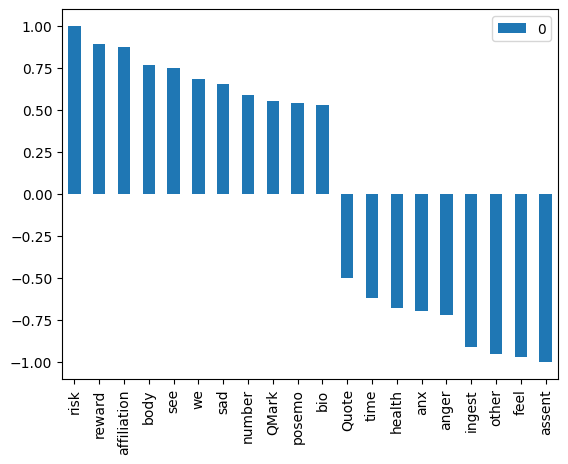

In [76]:
# Extract coefficient, normalize them and filter by importance, then plot

coefs = clf.coef_.copy()  # only kernel="linear" in SVC; or LogReg

coefs = coefs * np.linspace(-1, 1, len(clf.classes_))[:,np.newaxis]
coefs = coefs.sum(axis=0)
coefs = compute.normalize_coefs(coefs)

values, labels = compute.coef_filter(coefs, X_labels)
print(compute.coef_to_human(values, labels))

df_coefs = pd.DataFrame(values, index=labels)
df_coefs.plot.bar()

In [80]:
clf.coef_.min()

-1.260718798707047

---

### Baselines

In [52]:
# data
sel_study = "S1"      # one of: S1, S2, S1+S2
sel_var = "power"     # one of: power, dominance, prestige, power_f, dominance_f, prestige_f
                      #         optionally also: workplace_power, workplace_power_f  (only S2)

y = select_scores(sel_study, sel_var)

# convert continuous y variable to class variable
#y_cls = y.round()
#y_cls = y.astype(int)
y_cls = np.vectorize(round)(y)
y_lmh = quantize_scores(y)

In [64]:
# for regression

# dummy, baseline predictions
y_pred_mean = np.full_like(y, fill_value=np.mean(y))
y_pred_median = np.full_like(y, fill_value=np.median(y))
y_pred_oov = np.full_like(y, -1)  # ?
y_pred_rnd = np.random.rand(*y.shape) * 7

# scores
s_r2_true = r2_score(y, y)
s_r2_mean = r2_score(y, y_pred_mean)
s_r2_median = r2_score(y, y_pred_median)
s_r2_oov = r2_score(y, y_pred_oov)
s_r2_rnd = r2_score(y, y_pred_rnd)

s_mse_true = mean_squared_error(y, y)
s_mse_mean = mean_squared_error(y, y_pred_mean)
s_mse_median = mean_squared_error(y, y_pred_median)
s_mse_oov = mean_squared_error(y, y_pred_oov)
s_mse_rnd = mean_squared_error(y, y_pred_rnd)

# overview table
s_reg_df = pd.DataFrame(
    [s_r2_true, s_r2_mean, s_r2_median, s_r2_oov, s_r2_rnd,
     s_mse_true, s_mse_mean, s_mse_median, s_mse_oov, s_mse_rnd],
    columns=["score"],
    index=pd.MultiIndex.from_product([["r2", "mse"], ["y_true", "mean", "median", "oov", "random"]], names=["Measure", "y-values"]))

In [65]:
# for classification

# dummy, baseline predictions
y_17_pred_mean = np.full_like(y_cls, fill_value=np.mean(y_cls))
y_17_pred_median = np.full_like(y_cls, fill_value=np.median(y_cls))
y_17_pred_oov = np.full_like(y_cls, -1)  # ?
y_17_pred_rnd = np.random.randint(7, size=y_cls.shape)  # or quantize_scores(np.random.rand(*y.shape))

y_lmh_pred_mean = np.full_like(y_lmh, fill_value=np.mean(y_lmh))
y_lmh_pred_median = np.full_like(y_lmh, fill_value=np.median(y_lmh))
y_lmh_pred_oov = np.full_like(y_lmh, -1)  # ?
y_lmh_pred_rnd = np.random.randint(3, size=y_lmh.shape)

# scores
s_17_acc_true = accuracy_score(y_cls, y_cls)
s_17_acc_mean = accuracy_score(y_cls, y_17_pred_mean)
s_17_acc_median = accuracy_score(y_cls, y_17_pred_median)
s_17_acc_oov = accuracy_score(y_cls, y_17_pred_oov)
s_17_acc_rnd = accuracy_score(y_cls, y_17_pred_rnd)

s_lmh_acc_true = accuracy_score(y_lmh, y_lmh)
s_lmh_acc_mean = accuracy_score(y_lmh, y_lmh_pred_mean)
s_lmh_acc_median = accuracy_score(y_lmh, y_lmh_pred_median)
s_lmh_acc_oov = accuracy_score(y_lmh, y_lmh_pred_oov)
s_lmh_acc_rnd = accuracy_score(y_lmh, y_lmh_pred_rnd)

# overview table
s_clf_df = pd.DataFrame(
    [s_17_acc_true, s_17_acc_mean, s_17_acc_median, s_17_acc_oov, s_17_acc_rnd,
     s_lmh_acc_true, s_lmh_acc_mean, s_lmh_acc_median, s_lmh_acc_oov, s_lmh_acc_rnd],
    columns=["accuracy"],
    index=pd.MultiIndex.from_product(
        [["1..7", "low/mid/high"], ["y_true", "mean", "median", "oov", "rnd"]],
        names=["Classes", "y-values"]))

In [67]:
print("Baselines regression:")
display_html(s_reg_df.T)
print("Baselines classification:")
display_html(s_clf_df.T)

Baselines regression:


Measure 
 r2 
 mse 
 
 
 y-values 
 y_true 
 mean 
 median 
 oov 
 random 
 y_true 
 mean 
 median 
 oov 
 random 
 
 
 
 
 score 
 1.0 
 0.0 
 -0.013155 
 -37.273581 
 -6.117469 
 0.0 
 0.969716 
 0.982473 
 37.114504 
 6.901923

Baselines classification:


Classes 
 1..7 
 low/mid/high 
 
 
 y-values 
 y_true 
 mean 
 median 
 oov 
 rnd 
 y_true 
 mean 
 median 
 oov 
 rnd 
 
 
 
 
 accuracy 
 1.0 
 0.375 
 0.375 
 0.0 
 0.115 
 1.0 
 0.355 
 0.33 
 0.0 
 0.315